## Cluster the reviews that you collected in homework 5, by doing the following:

## --- COPY FROM HW5 TO GET REVIEWS ---

In [ ]:
import warnings
warnings.filterwarnings('ignore')

#pip install if necessary
!pip install bs4
!pip install numpy
!pip install nltk

# package and libary install
import matplotlib
from IPython.display import Image
matplotlib.use('Agg')
from bs4 import BeautifulSoup
import itertools
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
from nltk.corpus import state_union
from nltk.tag import pos_tag
from nltk.tokenize import PunktSentenceTokenizer
import numpy as np
from operator import itemgetter
import pandas as pd
import requests
import re
from string import punctuation


nltk.download('maxent_treebank_pos_tagger')
nltk.download('treebank')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

pd.options.display.max_colwidth=500

def getSoup(url):
    """
    Utility function which takes a url and returns a Soup object.
    """
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    return soup

def minMax(a):
    '''Returns the index of negative and positive review.'''
    
    # get the index of least rated user review
    minpos = a.index(min(a))
    
    # get the index of highest rated user review
    maxpos = a.index(max(a))
    
    return minpos, maxpos

def getReviews(soup):
    '''Function returns a negative and positive review for each movie.'''
    
    # get a list of user ratings
    user_review_ratings = [tag.previous_element for tag in 
                           soup.find_all('span', attrs={'class': 'point-scale'})]
    
    
    # find the index of negative and positive review
    n_index, p_index = minMax(list(map(int, user_review_ratings)))
    
    
    # get the review tags
    user_review_list = soup.find_all('a', attrs={'class':'title'})
    
    
    # get the negative and positive review tags
    n_review_tag = user_review_list[n_index]
    p_review_tag = user_review_list[p_index]
    
    # return the negative and positive review link
    n_review_link = "https://www.imdb.com" + n_review_tag['href']
    p_review_link = "https://www.imdb.com" + p_review_tag['href']
    
    return n_review_link, p_review_link

def getReviewText(review_url):
    '''Returns the user review text given the review url.'''
    
    # get the review_url's soup
    soup = getSoup(review_url)
    
    # find div tags with class text show-more__control
    tag = soup.find('div', attrs={'class': 'text show-more__control'})
    
    return tag.getText()

def getMovieTitle(review_url):
    '''Returns the movie title from the review url.'''
    
    # get the review_url's soup
    soup = getSoup(review_url)
    
    # find h1 tag
    tag = soup.find('h1')
    
    return list(tag.children)[1].getText()

def getNounChunks(user_review):
    
    # create the doc object
    doc = nlp(user_review)
    
    # get a list of noun_chunks
    noun_chunks = list(doc.noun_chunks)
    
    # convert noun_chunks from span objects to strings, otherwise it won't pickle
    noun_chunks_strlist = [chunk.text for chunk in noun_chunks]
    
    return noun_chunks_strlist

# limit to 250 movies
url = '''https://www.imdb.com/search/title/?title_type=feature&user_rating=1.0,10.0
    &genres=comedy&view=simple&sort=user_rating,desc&count=250&role=nm0001191'''
# get the soup object for main api url
movies_soup = getSoup(url)

# find all a-tags with class:None
movie_tags = movies_soup.find_all('a', attrs={'class': None})

# filter the a-tags to get just the titles
movie_tags = [tag.attrs['href'] for tag in movie_tags 
              if tag.attrs['href'].startswith('/title') & tag.attrs['href'].endswith('/')]

# remove duplicate links
movie_tags = list(dict.fromkeys(movie_tags))

# movie links
base_url = "https://www.imdb.com"
movie_links = [base_url + tag + 'reviews' for tag in movie_tags]

# get a list of soup objects
movie_soups = [getSoup(link) for link in movie_links]

# get all 500 movie review links
movie_review_list = [getReviews(movie_soup) for movie_soup in movie_soups]
movie_review_list = list(itertools.chain(*movie_review_list))

# get review text from the review link
review_texts = [getReviewText(url) for url in movie_review_list]

# get movie name from the review link
movie_titles = [getMovieTitle(url) for url in movie_review_list]

# construct a dataframe
df = pd.DataFrame({'movie': movie_titles, 'user_review_permalink': movie_review_list, 'user_review': review_texts})

# Convert reviews to a list
review_list = df['user_review'].tolist()

## --- END COPY - BEGIN HW ---

### 1. In Python, select any one of the clustering methods covered in this course. Run it over the collection of reviews, and show at least two different ways of clustering the reviews, e.g., changing k in k-Means clustering or changing where you “cut” in Agnes or Diana.  

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=20, max_df=0.4, max_features=20000, ngram_range=(1,1), stop_words='english')

# calculate the feature matrix
feature_matrix = vectorizer.fit_transform(review_list)

In [11]:
from scipy.cluster.vq import kmeans, vq
import seaborn as sns
import matplotlib.pyplot as plt

def kmeans_cluster_terms(num_clusters, top_n):
    # Generate cluster centers through the kmeans function
    cluster_centers, distortion = kmeans(feature_matrix.todense(), num_clusters)

    # Generate terms from the tfidf_vectorizer object
    terms = vectorizer.get_feature_names()

    # Display the top_n terms in that cluster
    key_terms = []
    for i in range(num_clusters):
        # Sort the terms and print top_n terms
        center_terms = dict(zip(terms, list(cluster_centers[i])))
        sorted_terms = sorted(center_terms, key=center_terms.get, reverse=True)
        key_terms.append(sorted_terms[:top_n])

    # label the clusters
    labels, _ = vq(feature_matrix.todense(), cluster_centers, check_finite=True)

    return cluster_centers, distortion, key_terms, labels

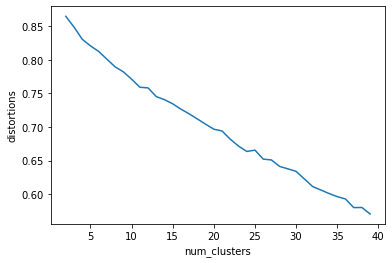

In [37]:
%matplotlib inline
# vary k from 2,10
distortions = []
centroids = []
top_10 = []
cluster_labels = []

num_clusters = range(2, 40)

for i in num_clusters:
    cluster_centers, distortion, key_terms, labels = kmeans_cluster_terms(i, 10)

    centroids.append(cluster_centers)
    distortions.append(distortion)
    top_10.append(key_terms)
    cluster_labels.append(labels)

# plot the elbow plot
elbow_plot_data = pd.DataFrame({'num_clusters': num_clusters,
                               'distortions': distortions})

sns.lineplot(x='num_clusters', y='distortions', data = elbow_plot_data)
plt.show()

In [27]:
# Import cosine_similarity to calculate similarity of movie plots
from sklearn.metrics.pairwise import cosine_similarity

# Calculate the similarity distance
similarity_distance = 1 - cosine_similarity(feature_matrix)

# Import modules necessary to plot dendrogram
from scipy.cluster.hierarchy import linkage, dendrogram

# Create mergings matrix
mergings = linkage(similarity_distance, method='complete')

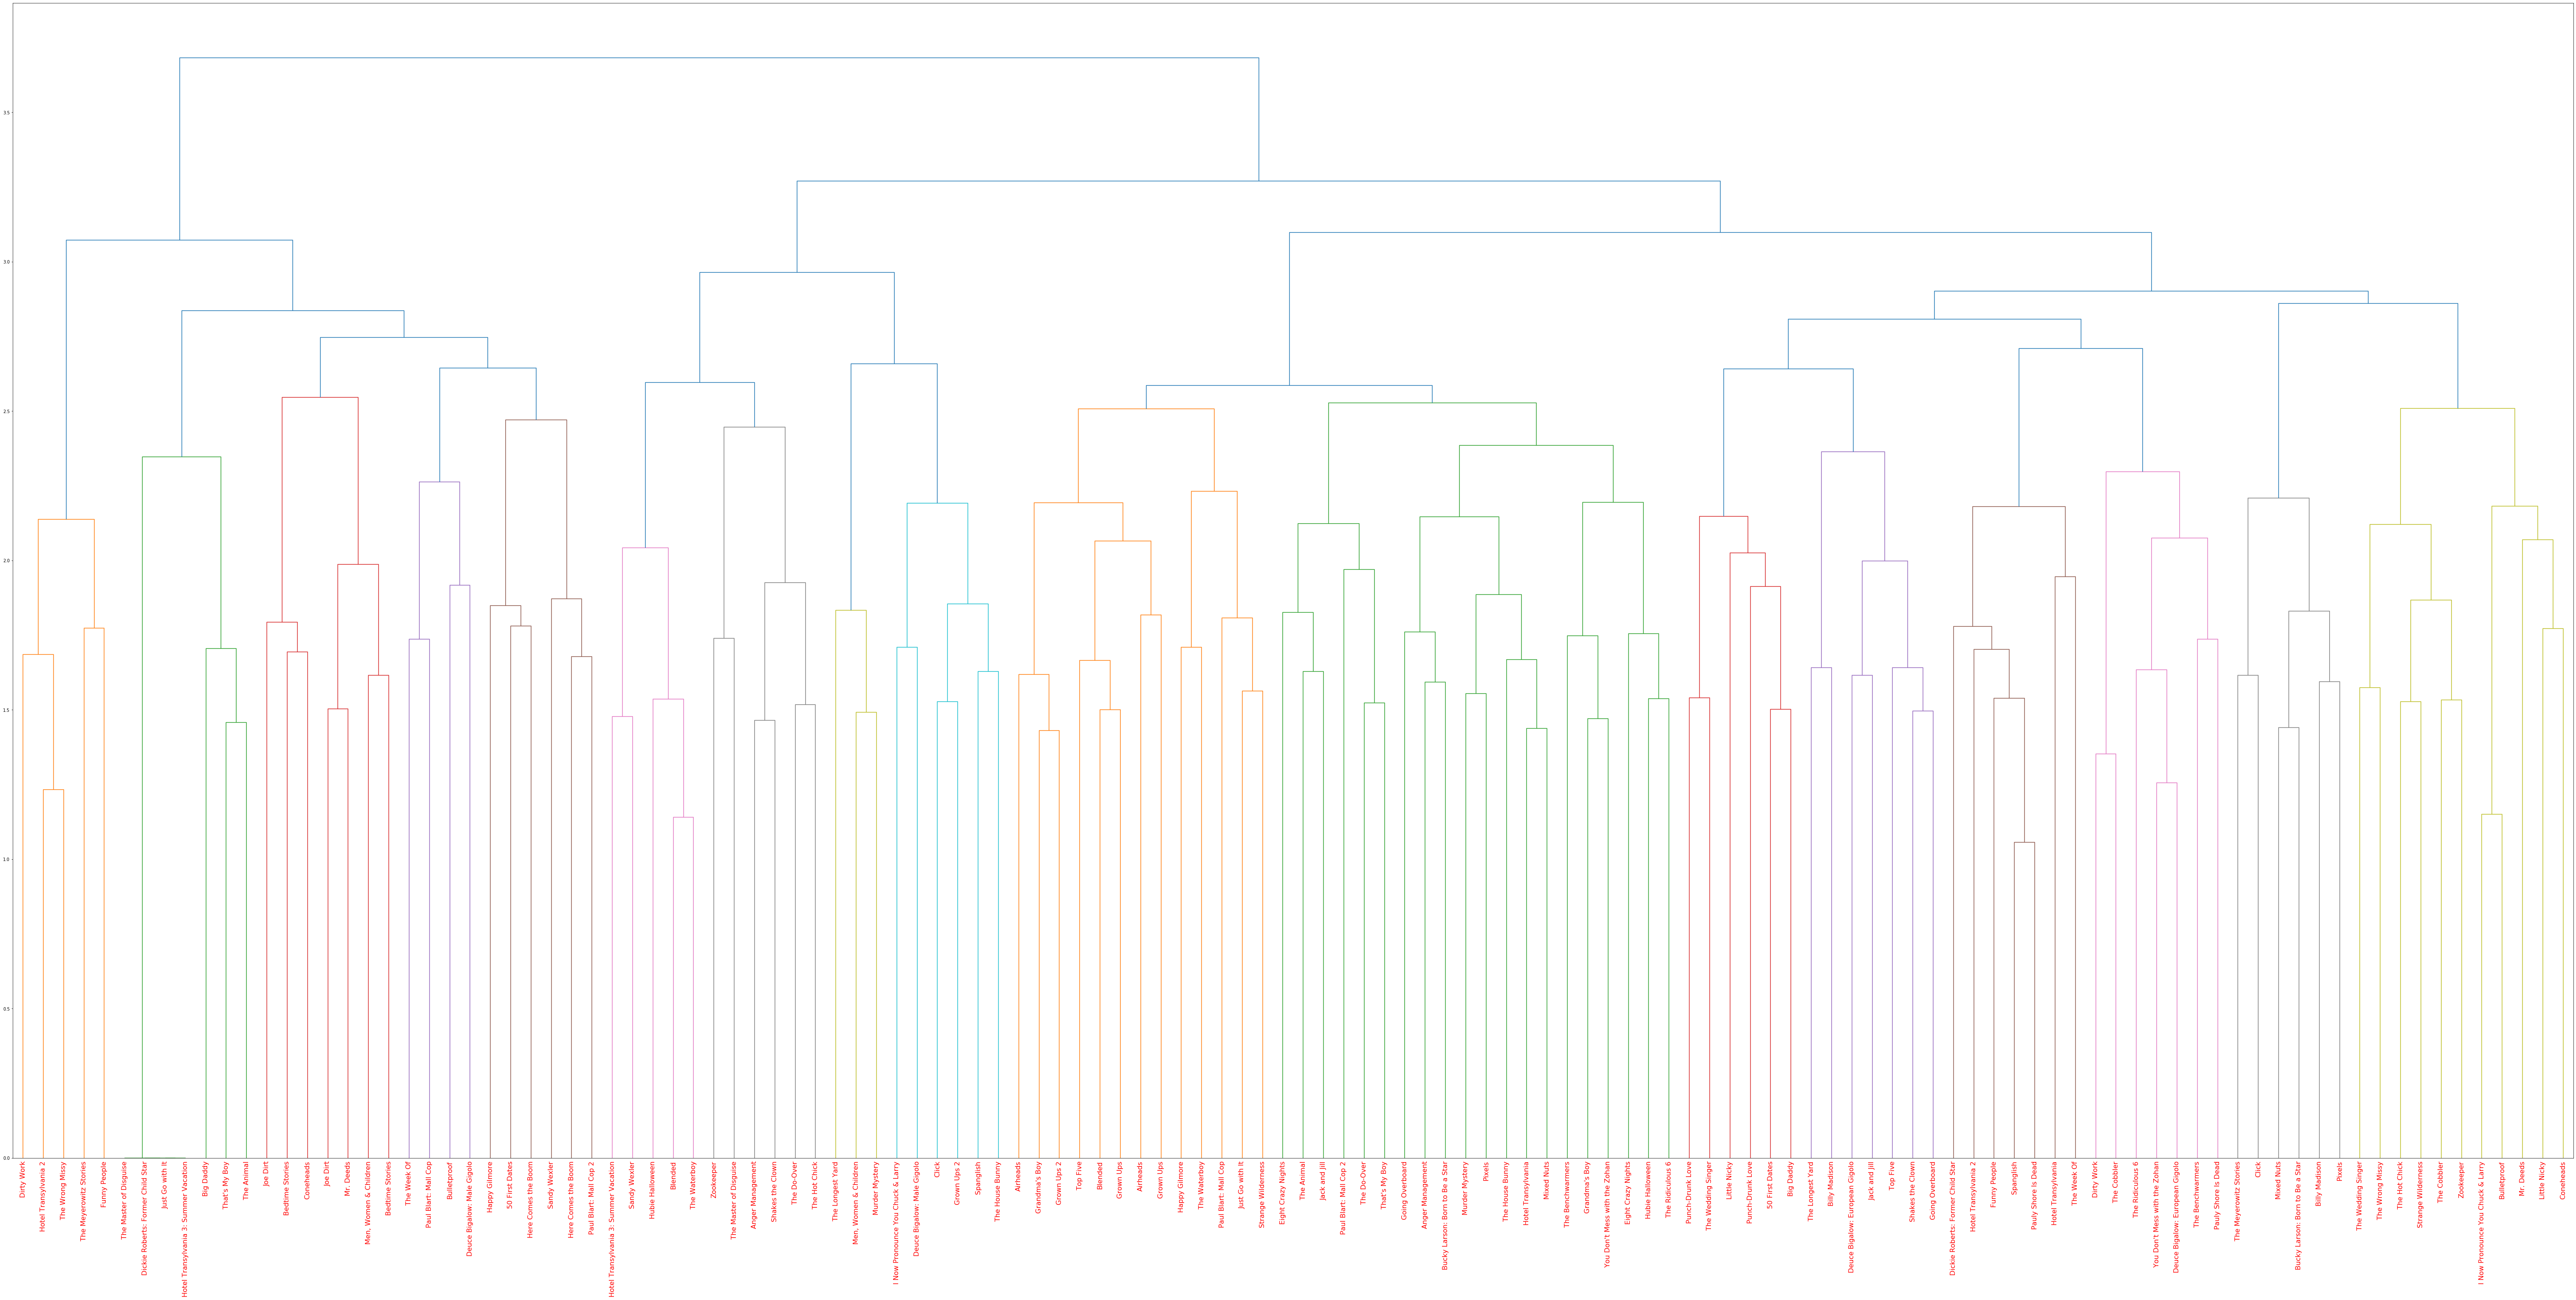

In [35]:
df2 = pd.DataFrame({'movie': movie_titles,'user_review': review_texts})

# complete linkage 

# Plot the dendrogram, using title as label column
dendrogram_ = dendrogram(mergings, orientation='top',
               labels=[x for x in df2['movie']],
               leaf_font_size=16
)

# Adjust the plot
fig = plt.gcf()
_ = [lbl.set_color('r') for lbl in plt.gca().get_xmajorticklabels()]
fig.set_size_inches(108, 50)

# Show the plotted dendrogram
plt.show()

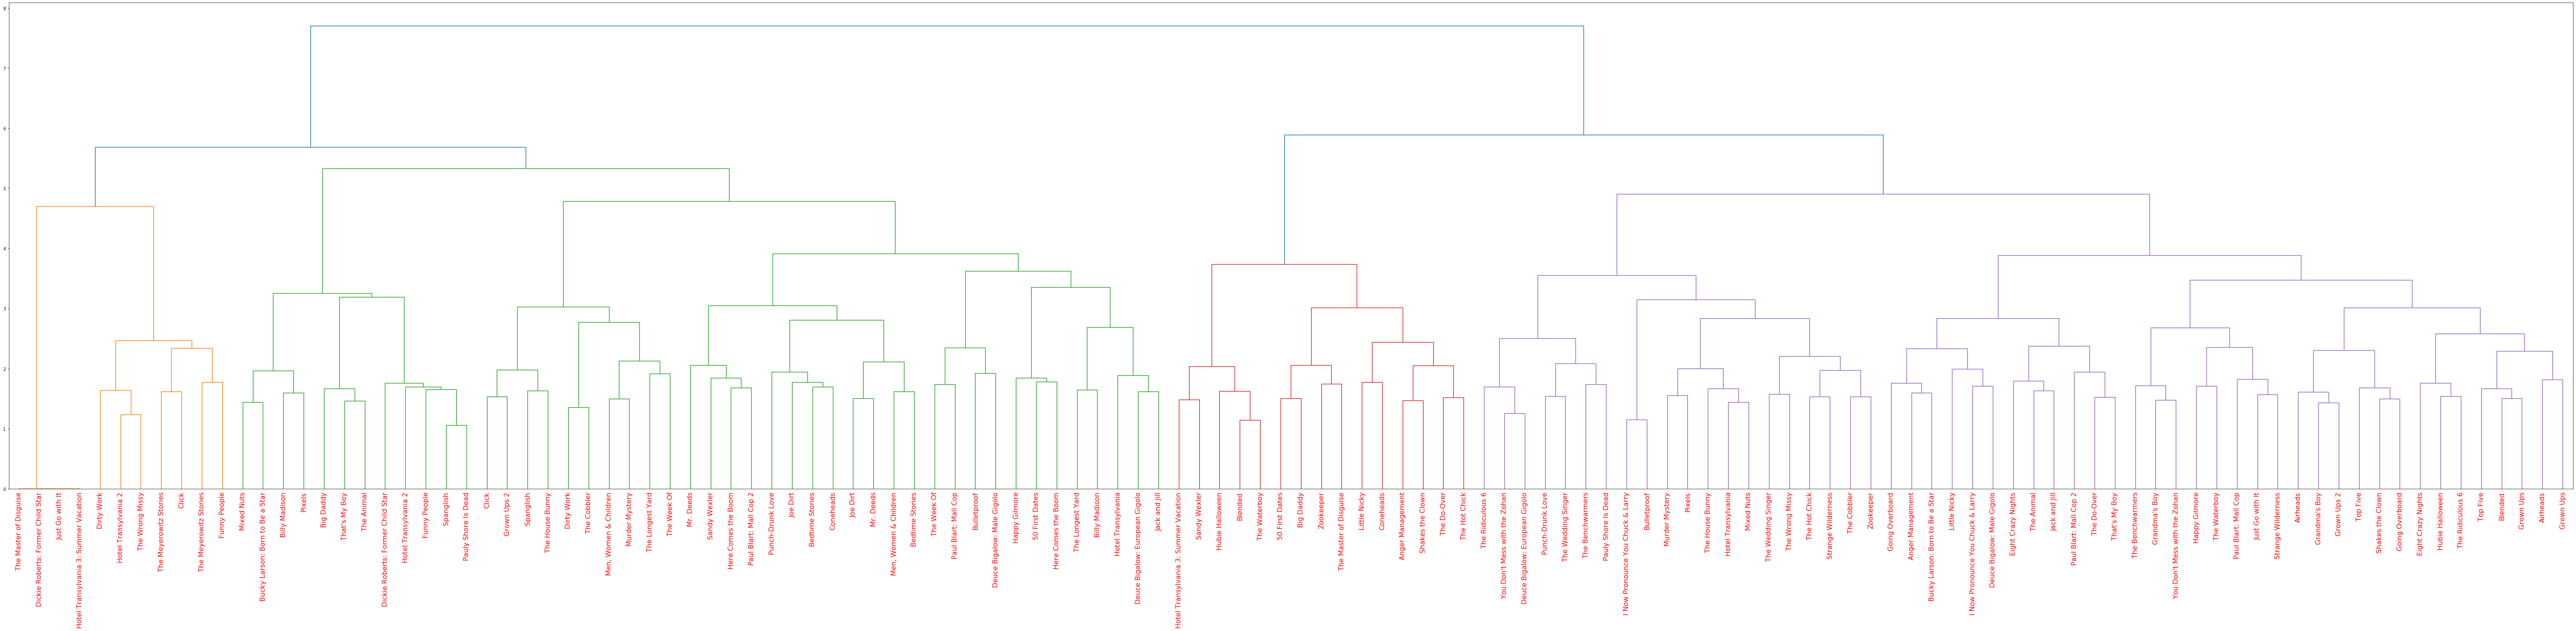

In [34]:
from scipy.cluster.hierarchy import ward

linkage_matrix = ward(similarity_distance)\

# ward linkage

# Plot the dendrogram, using title as label column
dendrogram_ = dendrogram(linkage_matrix,
               labels=[x for x in df2['movie']],
               leaf_rotation=90,
               leaf_font_size=16,
)

# Adjust the plot
fig = plt.gcf()
_ = [lbl.set_color('r') for lbl in plt.gca().get_xmajorticklabels()]
fig.set_size_inches(108, 21)

plt.show()

### 2. Try to write a short phrase to characterize (give a natural interpretation of) what each cluster is generally centered on semantically. Is this hard to do in some cases? If so, make note of that fact. 

I found this hard to do (primarily due to my novice nlp coding abilities). Just looking at the heirarchical trees, there appears to be some distinction between movies that brought out emotion in the reviews opposed to reviews that commmented on the humor or satire of the movie itself

### 3. Explain which of the two clustering results from question 1 is preferable (if one of them is), and why. 

I much prefer the heirarchical clustering approach for these movie reviews reviews. The difference between complete linkage and ward linkage was quite distinct. Ward linkage developed much broader clustering, while complete linkage developed finer/smaller clusters. I personally found k-means difficult to work with and gain any interpretation from. Depending on the use case, I would think that either linkage option is viable.